<strong style="color: #800020; font-size: 28px"> 

Análisis de la ordenación de la tasa de descenso

</strong>

En este notebook estaré desarrollando el análisis de la ordenación de la tasa de descenso por intervalo de score. 

El modelo principal será trabajado a través de gráfico de ordenación.

In [244]:
# Importación de las bibliotecas básicas
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from pivottablejs import pivot_ui

warnings.filterwarnings('ignore')

In [205]:
# Importación de la base de dato
df = pd.read_csv('modelos_rebaixamento_futebol.csv')

In [206]:
# Visualización de la base
df.head()

,Unnamed: 0,Time,Pontos,Jogos,Vitorias,Empates,Derrotas,Gols Feitos,Gols Sofridos,Final,Campeão,Rebaixado,Ano,Id,screbgeral,screbstd,screbminmax
0,0,Corinthians,59,31,17,8,6,40,21,1,1,0,2017,0,0.00,0.00,0.0
1,1,Palmeiras,54,31,16,6,9,48,33,2,0,0,2017,1,0.00,0.01,0.0
2,2,Santos,53,31,14,11,6,33,22,3,0,0,2017,2,0.00,0.03,0.0
3,3,Grêmio,51,31,15,6,10,45,28,4,0,0,2017,3,0.00,0.03,0.0
4,4,Cruzeiro,48,31,13,9,9,38,30,5,0,0,2017,4,0.03,0.15,0.0


In [207]:
# Comprensión de la ausencia de valores
df.isnull().sum()

Unnamed: 0       0
Time             0
Pontos           0
Jogos            0
Vitorias         0
Empates          0
Derrotas         0
Gols Feitos      0
Gols Sofridos    0
Final            0
Campeão          0
Rebaixado        0
Ano              0
Id               0
screbgeral       0
screbstd         0
screbminmax      0
dtype: int64

### Conclusión:

No hay ningún valor ausente.

In [211]:
# Definiendo intervalos homogéneos para los modelos de score
df['fx_screbgeral'] = pd.qcut(df['screbgeral'], q=4, precision=2) # Modelo general
df['fx_screbstd'] = pd.qcut(df['screbstd'], q=8, precision=2)     # Modelo con scaling - Estandarización
df['fx_screbminmax'] = pd.qcut(df['screbminmax'].round(2), q=2, precision=2) # Modelo con scaling - Normalización

In [212]:
# Comprendiedo la frecuencia por intervalos de score - Score General
df['fx_screbgeral'].value_counts()

fx_screbgeral
(-0.01, 0.018]    35
(0.018, 1.44]     35
(1.44, 31.4]      35
(31.4, 99.99]     35
Name: count, dtype: int64

In [213]:
# Comprendiedo la frecuencia por intervalos de score - Score Standard Scaler
df['fx_screbstd'].value_counts()

fx_screbstd
(-0.01, 0.01]     22
(0.1, 0.61]       18
(7.44, 27.2]      18
(60.02, 99.85]    18
(0.61, 2.42]      17
(2.42, 7.44]      17
(27.2, 60.02]     17
(0.01, 0.1]       13
Name: count, dtype: int64

In [214]:
# Comprendiedo la frecuencia por intervalos de score - Score MinMax Scaler
df['fx_screbminmax'].value_counts()

fx_screbminmax
(-0.01, 0.04]    71
(0.04, 100.0]    69
Name: count, dtype: int64

In [215]:
# Convirtiendo los intervalos de score en cadenas de texto (string)
df['fx_screbstd'] = df['fx_screbstd'].apply(lambda x: f"{x.left} a {x.right}")
df['fx_screbgeral'] = df['fx_screbgeral'].apply(lambda x: f"{x.left} a {x.right}")

In [216]:
# Eliminando valores negativos y fijando el cero como límite mínimo
df['fx_screbstd'] = df['fx_screbstd'].astype(str) # Convirtiendo en string
df.loc[df['fx_screbstd'] == '-0.01 a 0.01', 'fx_screbstd'] = '0 a 0.01' # Cambiando valores

In [217]:
# Resultado con visualización con tasa de descenso
df.groupby('fx_screbstd')['Rebaixado'].sum()/df.groupby('fx_screbstd')['Rebaixado'].count()

fx_screbstd
0 a 0.01         0.000000
0.01 a 0.1       0.000000
0.1 a 0.61       0.000000
0.61 a 2.42      0.000000
2.42 a 7.44      0.000000
27.2 a 60.02     0.411765
60.02 a 99.85    0.944444
7.44 a 27.2      0.222222
Name: Rebaixado, dtype: float64

In [218]:
# Observando la tasa de descenso por intervalos de punjante del modelo general
df.groupby('fx_screbgeral')['Rebaixado'].sum()/df.groupby('fx_screbgeral')['Rebaixado'].count()

fx_screbgeral
-0.01 a 0.018    0.000000
0.018 a 1.44     0.000000
1.44 a 31.4      0.114286
31.4 a 99.99     0.685714
Name: Rebaixado, dtype: float64

In [219]:
# Creando un dataframe con el volumen de descendidos por intervalos de score homogéneos - Standard Scaler
rebaixado_df = pd.DataFrame(df.groupby('fx_screbstd')['Rebaixado'].sum()).reset_index()

In [220]:
# Creando un dataframe con el volumen total de la base por intervalos de score homogéneos - Standard Scaler
total_df = pd.DataFrame(df.groupby('fx_screbstd')['Rebaixado'].count()).reset_index().rename(columns={'Rebaixado':'Total'})

In [221]:
# Unificación de las bases de volumen de descendidos y de total
pre_calculada = rebaixado_df.merge(total_df[['fx_screbstd', 'Total']], on='fx_screbstd')

# Calculando la tasa de descendidos
pre_calculada['Tasa Descenso'] = pre_calculada.Rebaixado/pre_calculada.Total

In [222]:
# Ordenación de los datos
pre_calculada = pre_calculada.sort_values(by='Tasa Descenso', ascending=True)

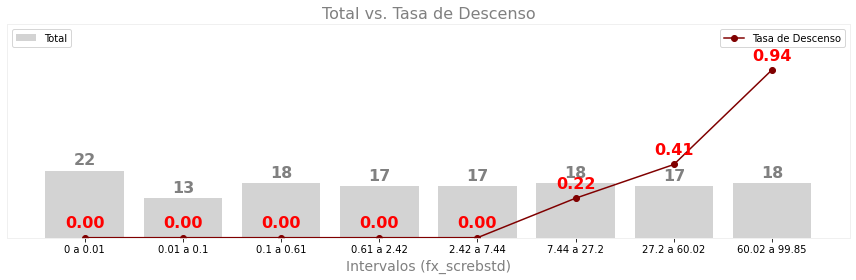

In [223]:
# Definición de la dimensión del gráfico
fig, ax1 = plt.subplots(figsize=(12, 4))

# Gráfico de barras (Total)
barras = ax1.bar(pre_calculada['fx_screbstd'], pre_calculada['Total'], color='#d3d3d3', label='Total')

# Ajustando el límite del eje Y del Total
ax1.set_ylim(0, 70)  # Límite ajustable
ax1.set_xlabel('Intervalos (fx_screbstd)',  fontsize=14, color='gray')
# ax1.set_ylabel('Total', color='blue')
ax1.tick_params(axis='y', labelcolor='blue', labelleft=False, colors='gray')  # Elimina los valores del eje Y primario

# Configuración de los límites del gráfico
ax1.spines['top'].set_color('#F0F0F0')
ax1.spines['right'].set_color('#F0F0F0')
ax1.spines['left'].set_color('#F0F0F0')
ax1.spines['bottom'].set_color('#F0F0F0')

# Eliminación de los valores del eje y
ax1.set_yticks([])

# Mostrando los valores del Total en las barras
for bar in barras:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval + 1,  # Posición del texto
             f'{yval}', ha='center', va='bottom',  # Alineación en el centro y en la parte superior de la barra
             fontsize=16, fontweight='bold', color='grey')  # Personaliza el estilo del texto

# Gráfico de línea (Tasa de Descenso)
ax2 = ax1.twinx()
ax2.plot(pre_calculada['fx_screbstd'], pre_calculada['Tasa Descenso'], color='#800000', marker='o', label='Tasa de Descenso')

# Ajustando el límite del eje Y de la Tasa de Descenso
ax2.set_ylim(0, 1.2)  # Límite ajustable
ax2.set_xlabel('Intervalos (fx_screbstd)',  fontsize=14, color='gray')
ax2.tick_params(axis='y', labelcolor='#800000', labelright=False, colors='gray') 

# Configuración de los límites del gráfico
ax2.spines['top'].set_color('#F0F0F0')
ax2.spines['right'].set_color('#F0F0F0')
ax2.spines['left'].set_color('#F0F0F0')
ax2.spines['bottom'].set_color('#F0F0F0')

# Eliminación de los valores del eje y
ax2.set_yticks([])

# Añadiendo los valores de la Tasa de Descenso en el gráfico
for i, valor in enumerate(pre_calculada['Tasa Descenso']):
    ax2.annotate(f"{valor:.2f}",  # Formato de los valores (2 decimales)
                 (i, valor),      # Coordenadas del punto
                 textcoords="offset points",  # Base para el desplazamiento
                 xytext=(0, 10),  # Desplazamiento vertical
                 ha='center',    # Alineación horizontal
                 color='red',    # Color del texto
                 fontsize=16,    # Tamaño de la fuente del texto
                 fontweight='bold')  # Negrita para los valores

# Títulos y leyendas
plt.title('Total vs. Tasa de Descenso', fontsize=16, color='gray')
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar el gráfico
plt.show()

### Conclusión:

La tasa de descenso está ordenada por los intervalos, de modo que cuanto mayor es el intervalo, mayor es la tasa, lo que indica que el modelo desempeñándose bien.

<strong style="color: #FF8C00; font-size: 28px"> 

Probabilidad de Descenso a la segunda división del Brasileirão 2024

</strong>


In [239]:
# Importación de la base de dato con probabilidad de los equipos en calir a la segunda división
tabela_2024 = pd.read_csv('scores_2024_brasileirao.csv').iloc[:,1:]

In [240]:
# Visualizando la base importada
tabela_2024.head()

,Posição,Time,Pontos,Jogos,Vitórias,Empates,Derrotas,Gols Marcados,Gols Sofridos,screbgeral,screbstd,screbminmax
0,1,Botafogo,64,31,19,7,5,49,26,0.00,0.00,0.0
1,2,Palmeiras,61,31,18,7,6,53,25,0.00,0.01,0.0
2,3,Fortaleza,57,31,16,9,6,41,32,0.00,0.01,0.0
3,4,Flamengo,55,31,16,7,8,50,37,0.00,0.01,0.0
4,5,Internacional,53,31,14,11,6,42,28,0.01,0.10,0.0


In [246]:
# Dimensión
tabela_2024.shape

(20, 12)

In [250]:
# Analisando ausencia de valores
tabela_2024.isnull().sum()

Posição          0
Time             0
Pontos           0
Jogos            0
Vitórias         0
Empates          0
Derrotas         0
Gols Marcados    0
Gols Sofridos    0
screbgeral       0
screbstd         0
screbminmax      0
dtype: int64

In [264]:
# Definiendo intervalos homogéneos para los modelos de score
tabela_2024['fx_screbstd'] = pd.qcut(tabela_2024['screbstd'], q=10, precision=2) # Modelo general

In [265]:
# Convirtiendo los intervalos de score en cadenas de texto (string)
tabela_2024['fx_screbstd'] = tabela_2024['fx_screbstd'].apply(lambda x: f"{x.left} a {x.right}")

In [266]:
# Eliminando valores negativos y fijando el cero como límite mínimo
tabela_2024['fx_screbstd'] = tabela_2024['fx_screbstd'].astype(str) # Convirtiendo en string
tabela_2024.loc[tabela_2024['fx_screbstd'] == '-0.01 a 0.01', 'fx_screbstd'] = '0 a 0.01' # Cambiando valores

In [269]:
# Probabilidad de descenso de cada equipo
tabela_2024[['Time', 'screbstd']].rename(columns={'screbstd':'Prob.'})

,Time,Prob.
0,Botafogo,0.00
1,Palmeiras,0.01
2,Fortaleza,0.01
3,Flamengo,0.01
4,Internacional,0.10
5,São Paulo,0.15
6,Bahia,0.29
7,Cruzeiro,0.32
8,Vasco,1.11
9,Atlético Mineiro,1.07
